In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from scipy import optimize
import math
%matplotlib inline 

In [2]:
data = scipy.io.loadmat('data/ex4data1.mat')

In [3]:
X = data['X']
y = data['y'].flatten()

In [4]:
m, _ = X.shape
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25;
num_labels = 10  

In [5]:
# Randomly select 100 data points to display
rand_indices = np.random.permutation(range(m))
sel = X[rand_indices[0:100], :]

/Users/andy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/andy/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
displayData.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  display_array[min(rows):max(rows), min(cols):max(cols)] = X[curr_ex, :].reshape(example_height, example_width) / max_val


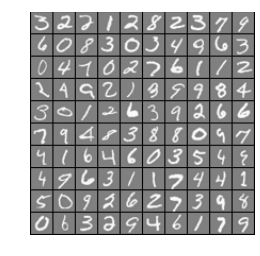

In [6]:
from displayData import displayData
displayData(sel)

In [7]:
weight = scipy.io.loadmat('data/ex4weights.mat')

In [8]:
nn_params = np.hstack((weight['Theta1'].T.ravel(), weight['Theta2'].T.ravel()))
nn_params.shape

(10285,)

In [9]:
Lambda = 0

In [10]:
def sigmoid(z):
    return 1 / (1 + np.e ** -z)
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

看得真是頭疼...不過這是類神經網路的cost funciton + ragular
$$\frac{1}{m}\sum_{i=1}^{m}\sum_{K}^{k=1}\left [ -y_{k}^{(i))}log((h_{\theta }(x^{(i)}))_{k})-(1 - y_{k}^{(i)})log(1-(h_{\theta }(x))_{k}) \right ] + \frac{\lambda }{2m}\left [ \sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta _{j,k}^{(1)})^{2} + \sum_{j=10}^{25}\sum_{k=1}^{400}(\Theta _{j,k}^{(2)})^{2} \right ]$$

In [11]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):

    theta1 = nn_params[:(input_layer_size + 1) * (hidden_layer_size)]
    theta1 = theta1.reshape((input_layer_size + 1, hidden_layer_size)).T
    theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size:]
    theta2 = theta2.reshape((hidden_layer_size + 1, num_labels)).T
    a1 = np.column_stack((np.ones(X.shape[0]),X))
    z2 = a1.dot(theta1.T)
    a2 = sigmoid(z2)
    a2 = np.column_stack((np.ones(a2.shape[0]),a2))
    a3 = sigmoid(a2.dot(theta2.T))
    
    H = a3
    y_tmp = [i-1 for i in y]
    ey = np.eye(num_labels, dtype=int)[y_tmp]
    
    T = -ey*np.log(H) - (1 - ey)*np.log(1-H)
    J = np.sum(T) / len(y)
    
    J = J + Lambda/(2*len(y)) * (np.sum(theta1 ** 2) + np.sum(theta2 ** 2))
    
    # Backpropagation algorithm
    
    delta3 = a3 - ey
    delta2 = (delta3.dot(theta2))[:,1:] * sigmoidGradient(z2)
    
    Delta1 = delta2.T.dot(a1) / len(y)
    Delta2 = delta3.T.dot(a2) / len(y)
    
    # Theta1_grad = Delta1 + Lambda
    grad = np.array([Delta1, Delta2])
    grad = np.hstack((Delta1.T.ravel(), Delta2.T.ravel()))
    return J, grad
    
J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)
print J
print grad.shape

0.287629165161
(10285,)


### Back propogation


$ \delta _{(l)}^{i} $表示第l層，第i個節點對y的誤差  
所以最後一層對y的誤差就是長這樣$\delta ^{(4)} = a^{(4)}-y$  
那在計算下一層的誤差公式長這樣$\delta ^{(3)} = (\Theta ^{(3)})^{T}\delta ^{(4)}.*g'(z^{(3)})$  
![](http://7d9rd6.com1.z0.glb.clouddn.com/wp-content/uploads/2016/04/scrn20160408231255.png)  
我們的最終目的是算出gradient，所以要對$\Theta$求導$$\Delta _{ij}^{(l)} = \frac{\partial }{\partial \Theta _{ij}^{(l)}} = a_{j}^{(l)}\delta _{i}^{l+1}$$
向量化的公式為$$\Delta ^{(l)} =\delta ^{l+1} (a^{(l)})^{T}$$

In [12]:
Lambda = 1.0

In [13]:
J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)

In [14]:
J

0.38448779624289398

In [15]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    return np.random.random_sample((L_out, L_in + 1)) * 2 * epsilon_init - epsilon_init
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
print initial_Theta1.shape
print initial_Theta2.shape

(25, 401)
(10, 26)


In [16]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.hstack((initial_Theta1.T.ravel(), initial_Theta2.T.ravel()))
print initial_nn_params.shape

(10285,)


In [17]:
from scipy.optimize import minimize
costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)[0]
gradFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)[1]

result = minimize(costFunc, initial_nn_params, method='CG', jac=gradFunc, options={'disp': True, 'maxiter': 50.0})
nn_params = result.x
cost = result.fun

         Current function value: 0.453105
         Iterations: 50
         Function evaluations: 141
         Gradient evaluations: 141


In [18]:
cost

0.4531047440274063

In [19]:
nn_params.shape

(10285,)

In [20]:
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                   (hidden_layer_size, input_layer_size + 1), order='F').copy()
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],
                   (num_labels, (hidden_layer_size + 1)), order='F').copy()

In [21]:
print Theta1.shape
print Theta1[:, 1:]

(25, 401)
[[ 0.10613912  0.01232904  0.09207937 ..., -0.11464782  0.06712496
   0.04257401]
 [-0.11123986  0.03413148  0.01965965 ...,  0.030058   -0.02233312
  -0.04580404]
 [-0.02572031 -0.03847126 -0.08583236 ..., -0.00699243 -0.04475642
   0.05427573]
 ..., 
 [ 0.06962361  0.05077208  0.10759632 ...,  0.06678419  0.07869445
   0.09291877]
 [-0.10897104 -0.08069552 -0.01098443 ...,  0.06090996 -0.0940268
   0.11010216]
 [-0.08750493 -0.09699897  0.07904499 ...,  0.09194267 -0.03654234
  -0.07638184]]


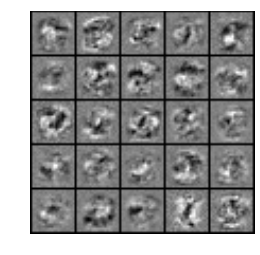

In [22]:
displayData(Theta1[:, 1:])

In [23]:
def predict(theta1, theta2, X):
    a1 = np.column_stack((np.ones(X.shape[0]),X))
    print a1.shape
    a2 = sigmoid(a1.dot(theta1.T))
    a2 = np.column_stack((np.ones(a2.shape[0]),a2))
    print a2.shape
    a3 = sigmoid(a2.dot(theta2.T))
    print a3.shape
    prediction = np.argmax(a3,axis=1)+1
    
    if True:
        import matplotlib.pyplot as p
        ex = np.random.randint(0, 5000)
        print 'Ans: ' + str(y[ex]), 'prediction: ' + str(prediction[ex])
        a = X[ex,:]
        a = a.reshape([20,20])
        p.imshow(a)
        p.show()

    return prediction

(5000, 401)
(5000, 26)
(5000, 10)
Ans: 5 prediction: 5


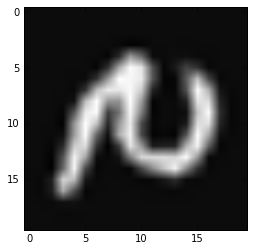

In [24]:
pred = predict(Theta1, Theta2, X)

accuracy = np.mean(np.double(pred == y)) * 100

In [25]:
accuracy

96.780000000000001